In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
#arrival and service rate
lamb = 20
mu =5
shift_hours =8

np.random.seed(1)

Defines the key queueing parameters and random seed:  
* `lamb = 20` → average **arrival rate** (calls/hour)  
* `mu   = 5`  → average **service rate** (calls handled per agent per hour)  
* `shift_hours = 8` → length of the working shift  
* `np.random.seed(1)` → fixes the random sequence so every run is reproducible.

In [47]:
# Simulate exponential data
inter = np.random.exponential(1 / lamb, int(lamb * shift_hours * 1.5))
arrivals = np.cumsum(inter)
arrivals = arrivals[arrivals < shift_hours]
N = len(arrivals)

# Create random service time
service = np.random.exponential(1 / mu, N)

Creates the raw data for the shift:  
1. Generates exponentially-distributed inter-arrival times, then converts them to **absolute arrival times** that fall inside the 8-hour window (`arrivals`).  
2. Counts how many calls actually arrive (`N`).  
3. Generates **service times** for each of those calls, also from an exponential distribution.  
The result is two aligned arrays—`arrivals` and `service`—that will drive every later simulation.


In [48]:
def simulate_queue(s):
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)
    dep_time = []

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + service[i]
        next_free[j] = end
        dep_time.append(end)
        system_size[i] = np.sum(np.array(dep_time) > t)

    return wait_times, system_size


wait_times_5_agents, system_size_5_agents = simulate_queue(5)
print("Average wait time:", np.mean(wait_times_5_agents))
print("Average system size:", np.mean(system_size_5_agents))

Average wait time: 0.08422684260138112
Average system size: 6.815950920245399


* Builds a function `simulate_queue(s)` that models an **M/M/s** queue (multi-server, exponential arrivals & service).  
  * Tracks the next free time of each agent, waiting time for each caller, and instantaneous system size.  
* Immediately calls the function with `s = 5` agents and prints:  
  * **Average wait time** for callers.  
  * **Average number in system** (calls waiting + in service).  

In [49]:
rho = lamb / mu
l_analytic=rho/(1-rho)
w_analytic=l_analytic/lamb
print("Average wait time:", w_analytic)
print("Average system size:", l_analytic)

Average wait time: -0.06666666666666667
Average system size: -1.3333333333333333


Calculates classic **M/M/1** formulas using ρ = λ / μ, giving:  
* **Average number in system**  \(L = ρ / (1 − ρ)\)  
* **Average wait time**         \(W = L / λ\)  

In [50]:
threshold=5
results=[]
for s in range(1,6):
  w,q=simulate_queue(s)
  waits_min=w*60
  p95_wait=np.percentile(waits_min,95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th pct wait(min)','Avg system size'])
print(df)
good=df[df['95th pct wait(min)']<=threshold]
if not good.empty:
  best_s=int(good.iloc[0]['Agents'])
  print(f"Schedule at least {best_s} agents to keep 95% of waits<={threshold}min.")
else:
  print("Even 5 agents can't meet the 5 min ")

   Agents  Avg wait(min)  95th pct wait(min)  Avg system size
0       1     808.232100         1488.275544        65.993865
1       2     284.004529          520.338714        49.042945
2       3     109.126322          191.268183        29.423313
3       4      23.259675           39.865347        11.846626
4       5       5.053611           15.062201         6.815951
Even 5 agents can't meet the 5 min 


Loops over agent counts **1 → 5** and records for each:  
* Mean wait (minutes)  
* 95th-percentile wait (minutes)  
* Mean system size  

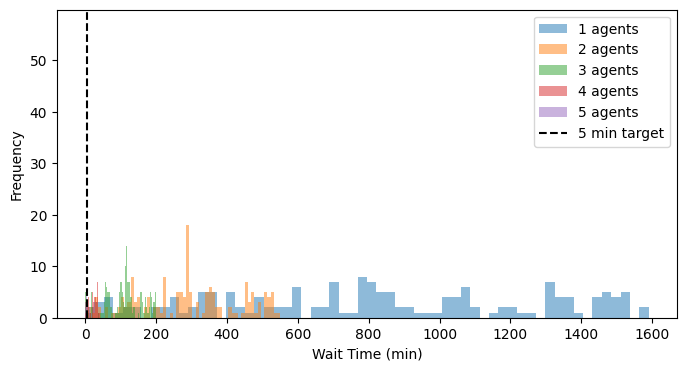

In [51]:
plt.figure(figsize=(8, 4))
for s in[1,2,3,4,5]:
  w,_=simulate_queue(s)
  plt.hist(w*60,bins=60,alpha=0.5,label=f'{s} agents')
plt.axvline(threshold,color='k',linestyle='--',label='5 min target')
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Draws overlapping histograms of **wait times** (in minutes) for 1–5 agents and marks the 5-minute service-level target with a dashed vertical line. This visualises how adding agents shifts the entire wait-time distribution.

In [52]:
# Time varying
def simulate_queue_timevarying(s):
  periods=[(0,2,30),(2,6,20),(6,8,40)]
  arrival=[]
  for start,end,lam in periods:
    duration=end-start
    inter=np.random.exponential(1/lam,int(lam*duration*1.5))
    ts=np.cumsum(inter)+start
    arrival.extend(ts[ts<end])

  arrivals = np.array(arrival)

  arrivals.sort()
  N=len(arrivals)
  service=np.random.exponential(1/mu,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait_times[i]=start-t
    next_free[j]=start+service[i]
  return wait_times
w_tv=simulate_queue_timevarying(5)
print("Average wait time(min):",w_tv.mean()*60)

Average wait time(min): 28.94050166996809


This imulates a more realistic scenario where the number of incoming calls changes over time. The function `simulate_queue_timevarying(s)` breaks the 8-hour shift into three time blocks, each with a different arrival rate:

| Time Period (hours) | Call Arrival Rate (λ) |
|---------------------|------------------------|
| 0–2 hours           | 30 calls/hour          |
| 2–6 hours           | 20 calls/hour          |
| 6–8 hours           | 40 calls/hour          |

The simulation is run using **5 agents**, and it calculates the **average customer wait time** (in minutes).  
This setup helps to understand how well the call center can handle busy and quiet periods throughout the day, and how fluctuations in call volume impact the overall customer experience.

In [53]:
# Customer abondenment
def simulate_with_abandon(s,patience=5/60):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  abandons=0
  waits=[]
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait=start-t
    if wait>=patience:
      abandons=abandons+1
    else:
      waits.append(wait)
      next_free[j]=start+service[i]
  return np.array(waits),abandons/len(arrivals)
waits,abandonment=simulate_with_abandon(5)
print("Average wait time(min):",waits.mean()*60)
print("Abandonment rate:",abandonment)

Average wait time(min): 0.6160260819372596
Abandonment rate: 0.08917197452229299


Defines `simulate_with_abandon(s, patience)`, where callers will hang up if their wait exceeds **5 minutes** (`patience = 5/60` hours).  
Outputs:  
* Mean wait (minutes) among those who stay.  
* **Abandonment rate** (fraction of callers who give up).  

In [54]:
# Optimal Staffing
c_agent=20
c_wait=0.50
costs=[]
for s in range(1,6):
  w,_=simulate_with_abandon(s)
  total_wait_cost=w.sum()*60*c_wait
  staff_cost=s*c_agent*shift_hours
  costs.append((s,staff_cost+total_wait_cost))
opt=min(costs,key=lambda x:x[1])
print("Agent count,total cost:")
for s,c in costs:print(f"s={s}:${c:,.0f}")
print(f"optimal s by cost={opt[0]}")

Agent count,total cost:
s=1:$198
s=2:$391
s=3:$586
s=4:$718
s=5:$830
optimal s by cost=1


    Avg wait(min)  95th pct wait(min)
0        2.150138            4.439082
1        1.900674            4.666930
2        2.018578            4.702022
3        1.894927            4.813067
4        1.772763            4.712760
5        2.565484            4.493289
6        1.660560            4.642374
7        2.477172            4.734984
8        2.534343            4.621639
9        2.117772            4.817771
10       2.107133            4.940171
11       2.348147            4.670139
12       1.904122            4.843447
13       2.573250            4.840325
14       2.318277            4.730032
15       2.474544            4.707353
16       2.337149            4.670702
17       1.957499            4.715729
18       2.873523            4.706679
19       2.452938            4.791494
20       2.227883            4.708684
21       2.268363            4.765408
22       1.784975            3.924112
23       2.075801            4.858744
24       2.259764            4.742836
25       2.8

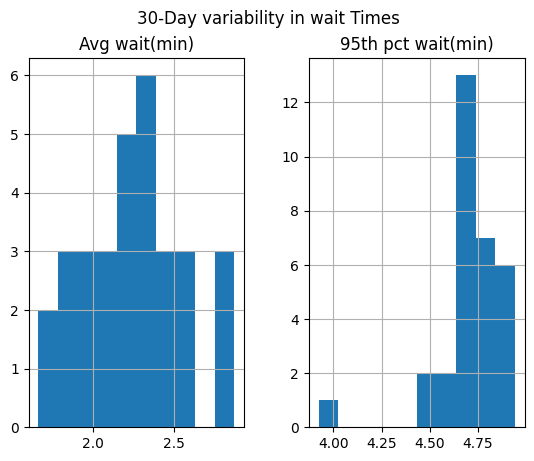

,Avg wait(min),95th pct wait(min)
count,31.000000,31.000000
mean,2.252806,4.707097
std,0.306109,0.182011
min,1.660560,3.924112
25%,2.047189,4.670421
50%,2.259764,4.717236
75%,2.463741,4.815419
max,2.873523,4.940171


In [55]:
days=31
daily=[]
for _ in range(days):
  w,_=simulate_with_abandon(opt[0])
  daily.append((w.mean()*60,np.percentile(w*60,95)))
df=pd.DataFrame(daily,columns=['Avg wait(min)','95th pct wait(min)'])
print(df)
df.hist(bins=10)
plt.suptitle('30-Day variability in wait Times')
plt.show()
df.describe()